In [1]:
from datasets import load_dataset

dataset = load_dataset("GangGreenTemperTatum/lfw-sample-organized")

README.md:   0%|          | 0.00/314 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/8.65M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/200 [00:00<?, ? examples/s]

In [2]:
dataset['train'][0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=250x250>,
 'category': 'good'}

```bash
save pillow image to disk
grab label
define fo sample - pillow image path
define a field for classiciation based on label
```

Saving images to: /Users/ads/git/toronto-visual-ai-hackathon-2025/dataset/lfw-organized
Processed 20/200 images
Processed 40/200 images
Processed 60/200 images
Processed 80/200 images
Processed 100/200 images
Processed 120/200 images
Processed 140/200 images
Processed 160/200 images
Processed 180/200 images
Processed 200/200 images
 100% |█████████████████| 200/200 [151.5ms elapsed, 0s remaining, 1.3K samples/s]       

Created FiftyOne dataset: lfw_organized
Number of samples: 200
  good: 100 images
  bad: 100 images



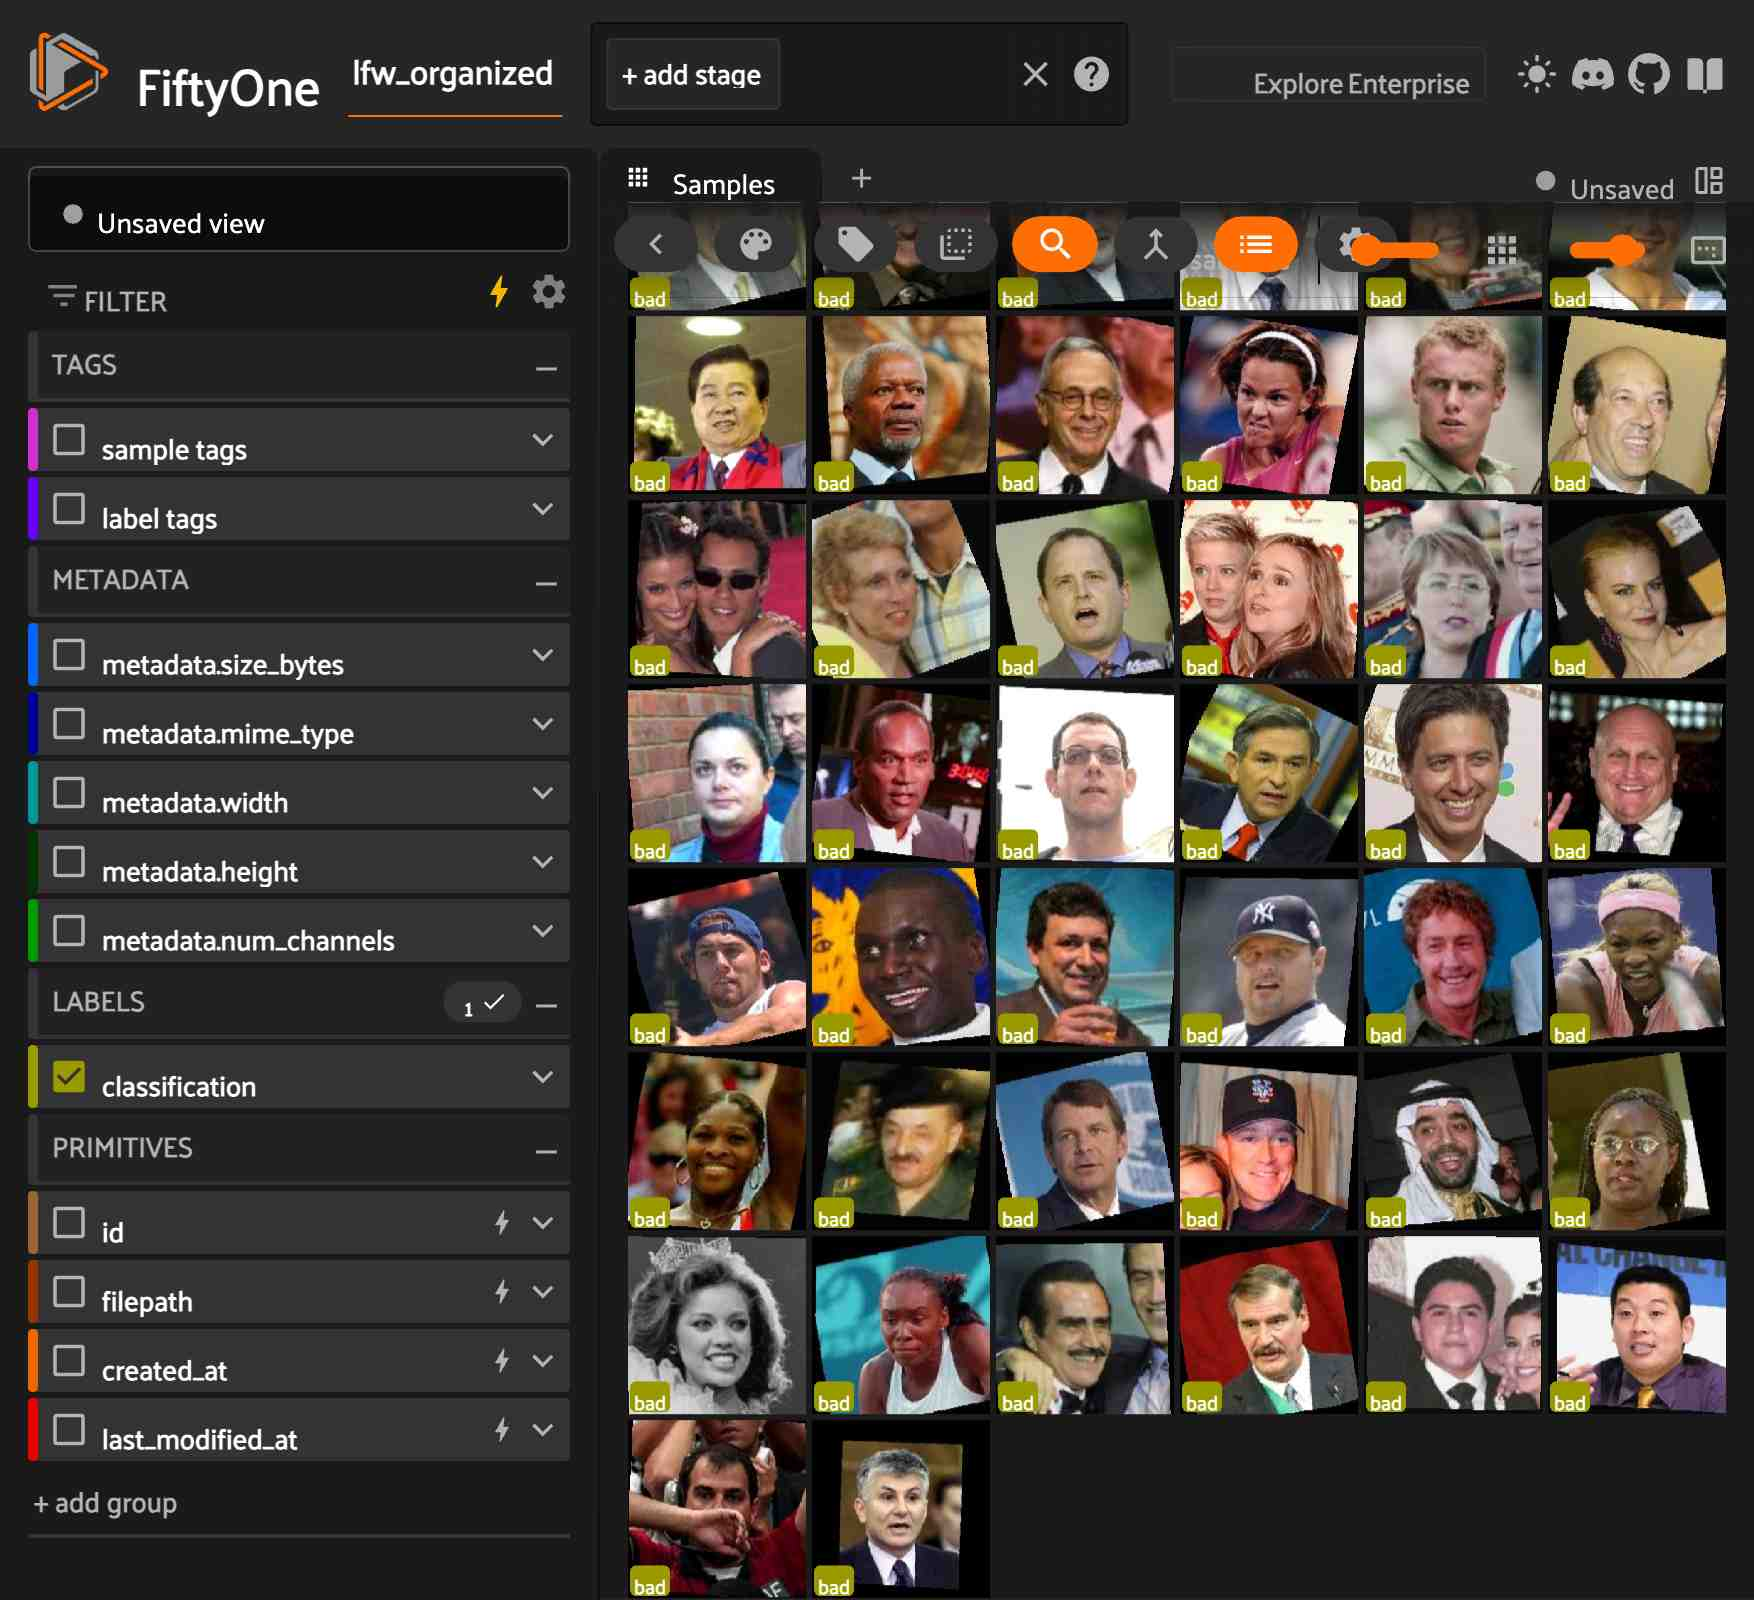

In [ ]:
import os
import fiftyone as fo
from PIL import Image
import uuid

current_dir = os.getcwd()
if os.path.basename(current_dir) == "notebooks":
    project_root = os.path.dirname(current_dir)
else:
    project_root = current_dir

dataset_dir = os.path.join(project_root, "dataset", "lfw-organized")
good_dir = os.path.join(dataset_dir, "good")
bad_dir = os.path.join(dataset_dir, "bad")

os.makedirs(good_dir, exist_ok=True)
os.makedirs(bad_dir, exist_ok=True)

print(f"Saving images to: {dataset_dir}")

samples = []

for i, example in enumerate(dataset["train"]):
    img = example["image"]
    category = example["category"]

    save_dir = good_dir if category == "good" else bad_dir

    filename = f"{category}_{uuid.uuid4()}.jpg"
    filepath = os.path.join(save_dir, filename)

    img.save(filepath)

    sample = fo.Sample(filepath=filepath)

    sample["classification"] = fo.Classification(label=category)

    samples.append(sample)

    if (i+1) % 20 == 0:
        print(f"Processed {i+1}/{len(dataset['train'])} images")

fo_dataset = fo.Dataset("lfw_organized")
fo_dataset.add_samples(samples)

print(f"\nCreated FiftyOne dataset: {fo_dataset.name}")
print(f"Number of samples: {len(fo_dataset)}")

categories = fo_dataset.count_values("classification.label")
for category, count in categories.items():
    print(f"  {category}: {count} images")

session = fo.launch_app(fo_dataset)

Loaded dataset: lfw_organized with 200 samples
Classifications in dataset:
  bad: 100 samples
  good: 100 samples
Found 100 good samples and 100 bad samples

Comparison 1:
  Good: /Users/ads/git/toronto-visual-ai-hackathon-2025/dataset/lfw-organized/good/good_12e0f2a0-065d-4d75-b4e3-727742f3e348.jpg
  Bad: /Users/ads/git/toronto-visual-ai-hackathon-2025/dataset/lfw-organized/bad/bad_37cf1939-3691-4470-bf36-486ec82969a9.jpg


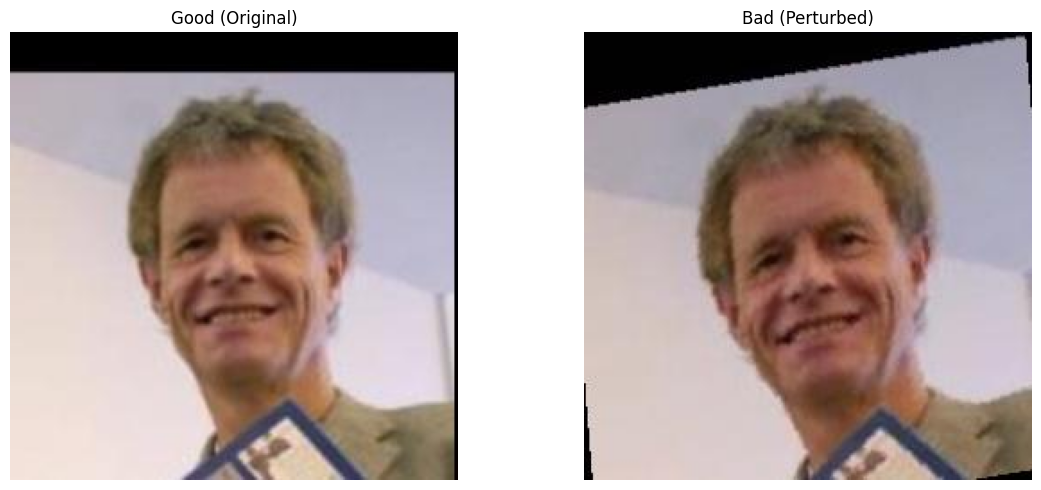


Comparison 2:
  Good: /Users/ads/git/toronto-visual-ai-hackathon-2025/dataset/lfw-organized/good/good_d8f2c6db-9833-4452-be51-6f798b18b1c8.jpg
  Bad: /Users/ads/git/toronto-visual-ai-hackathon-2025/dataset/lfw-organized/bad/bad_e2348109-dd24-452c-9faf-572db7317255.jpg


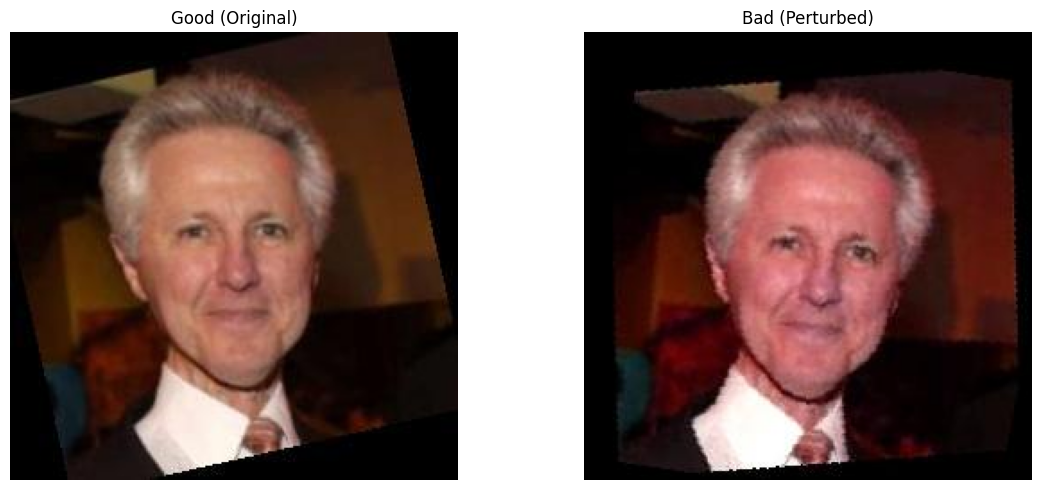


Comparison 3:
  Good: /Users/ads/git/toronto-visual-ai-hackathon-2025/dataset/lfw-organized/good/good_6e6e1c2e-f0d2-4bdb-9bd2-87993a8706e7.jpg
  Bad: /Users/ads/git/toronto-visual-ai-hackathon-2025/dataset/lfw-organized/bad/bad_782b34d7-8b5a-4dd3-a28c-286c0cfd69b2.jpg


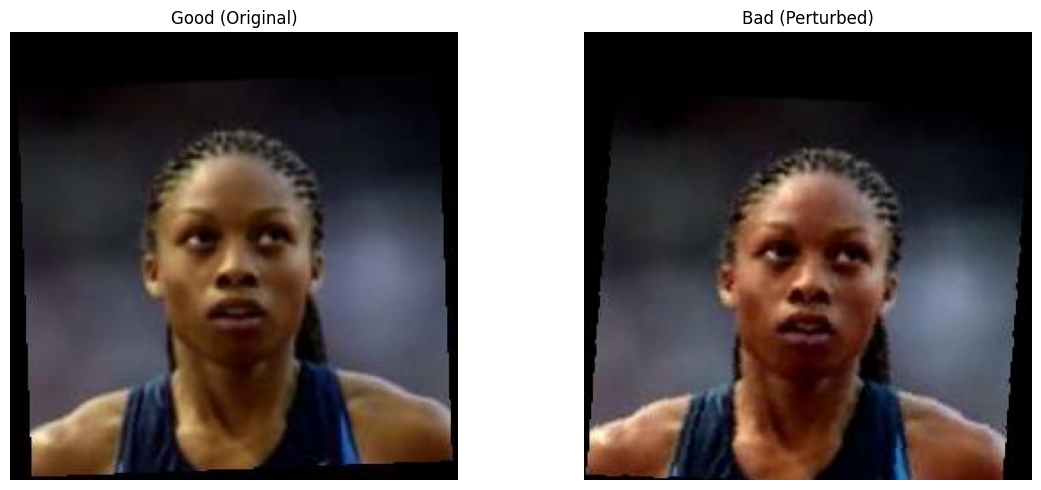


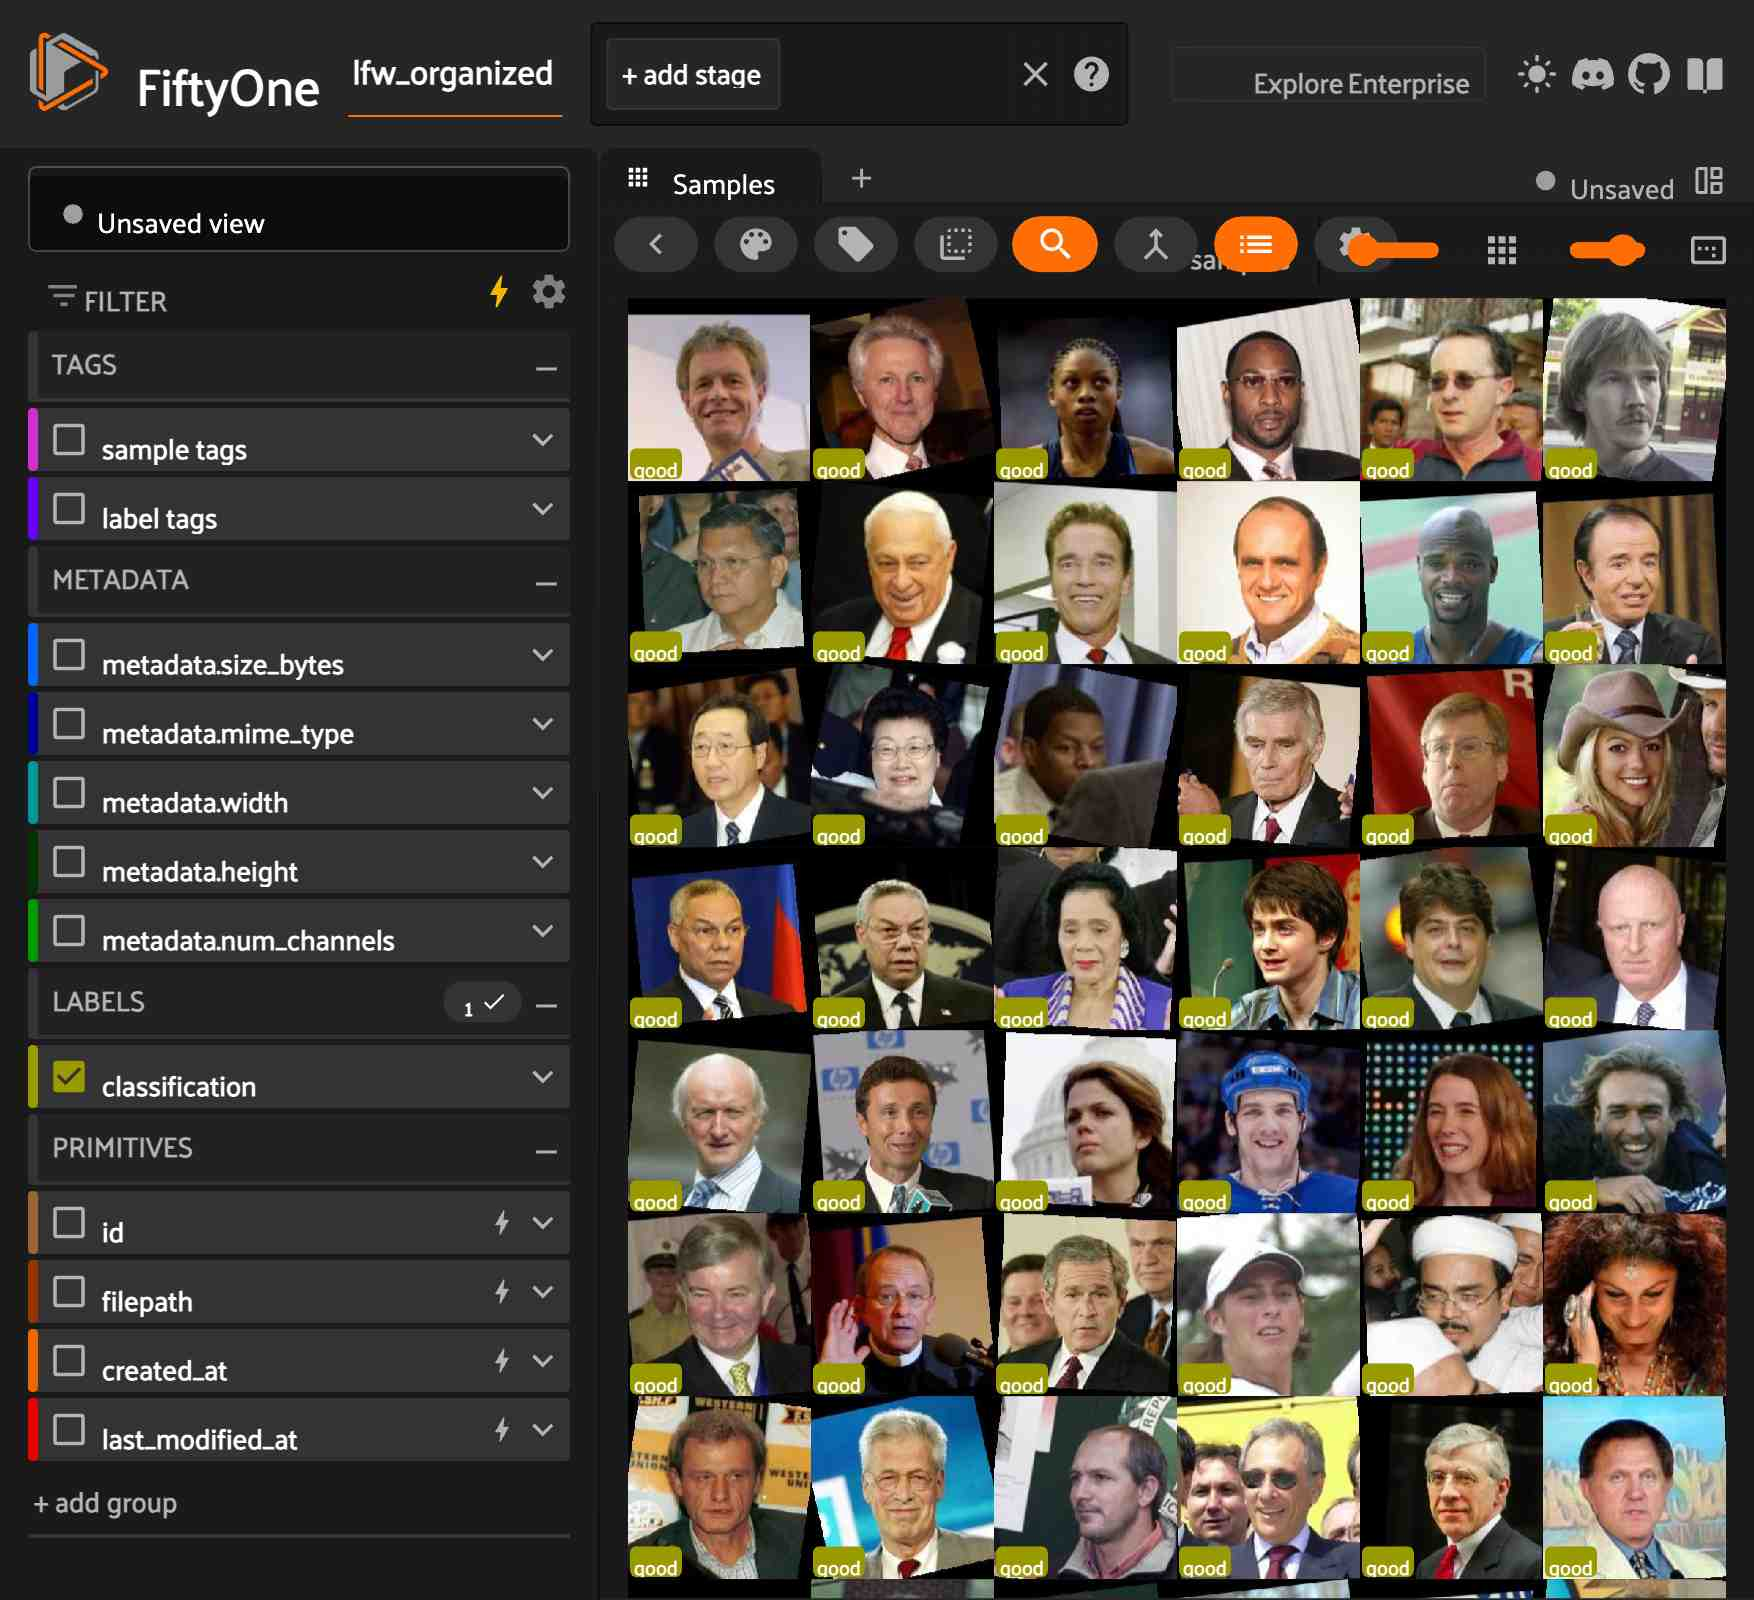

In [ ]:
import fiftyone as fo
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

dataset_name = "lfw_organized"
fo_dataset = fo.load_dataset(dataset_name)

print(f"Loaded dataset: {fo_dataset.name} with {len(fo_dataset)} samples")

classifications = fo_dataset.count_values("classification.label")
print("Classifications in dataset:")
for label, count in classifications.items():
    print(f"  {label}: {count} samples")

good_samples = fo_dataset.match({"classification.label": "good"})
bad_samples = fo_dataset.match({"classification.label": "bad"})

print(f"Found {len(good_samples)} good samples and {len(bad_samples)} bad samples")

def show_comparison(good_sample, bad_sample, figsize=(12, 5)):
    good_img = Image.open(good_sample.filepath)
    bad_img = Image.open(bad_sample.filepath)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

    ax1.imshow(good_img)
    ax1.set_title("Good (Original)")
    ax1.axis("off")

    ax2.imshow(bad_img)
    ax2.set_title("Bad (Perturbed)")
    ax2.axis("off")

    plt.tight_layout()
    plt.show()

    return fig

num_pairs = 3

good_sample_ids = good_samples.values("id")[:num_pairs]
bad_sample_ids = bad_samples.values("id")[:num_pairs]

for i in range(min(len(good_sample_ids), len(bad_sample_ids))):
    good_sample = fo_dataset[good_sample_ids[i]]
    bad_sample = fo_dataset[bad_sample_ids[i]]

    print(f"\nComparison {i+1}:")
    print(f"  Good: {good_sample.filepath}")
    print(f"  Bad: {bad_sample.filepath}")

    show_comparison(good_sample, bad_sample)

session = fo.launch_app(fo_dataset)

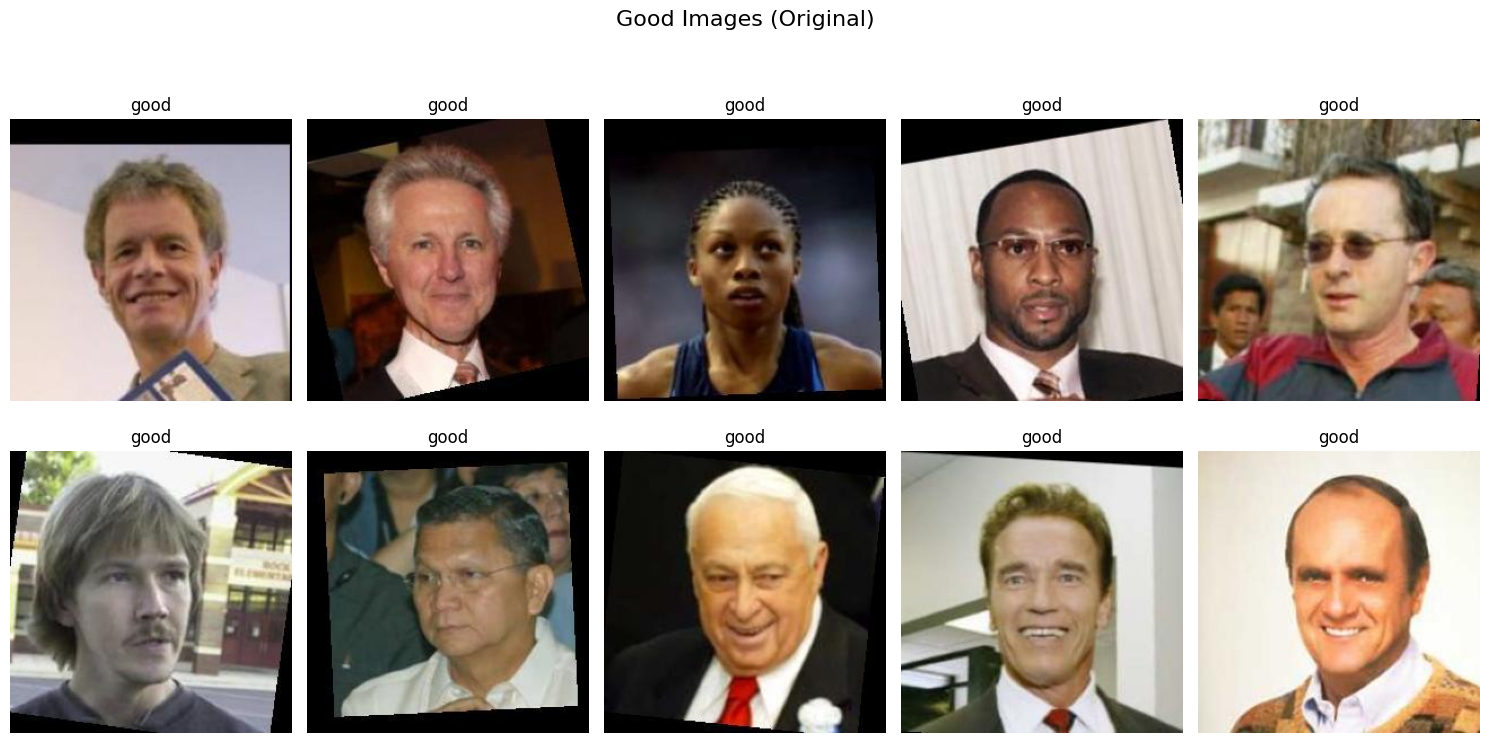

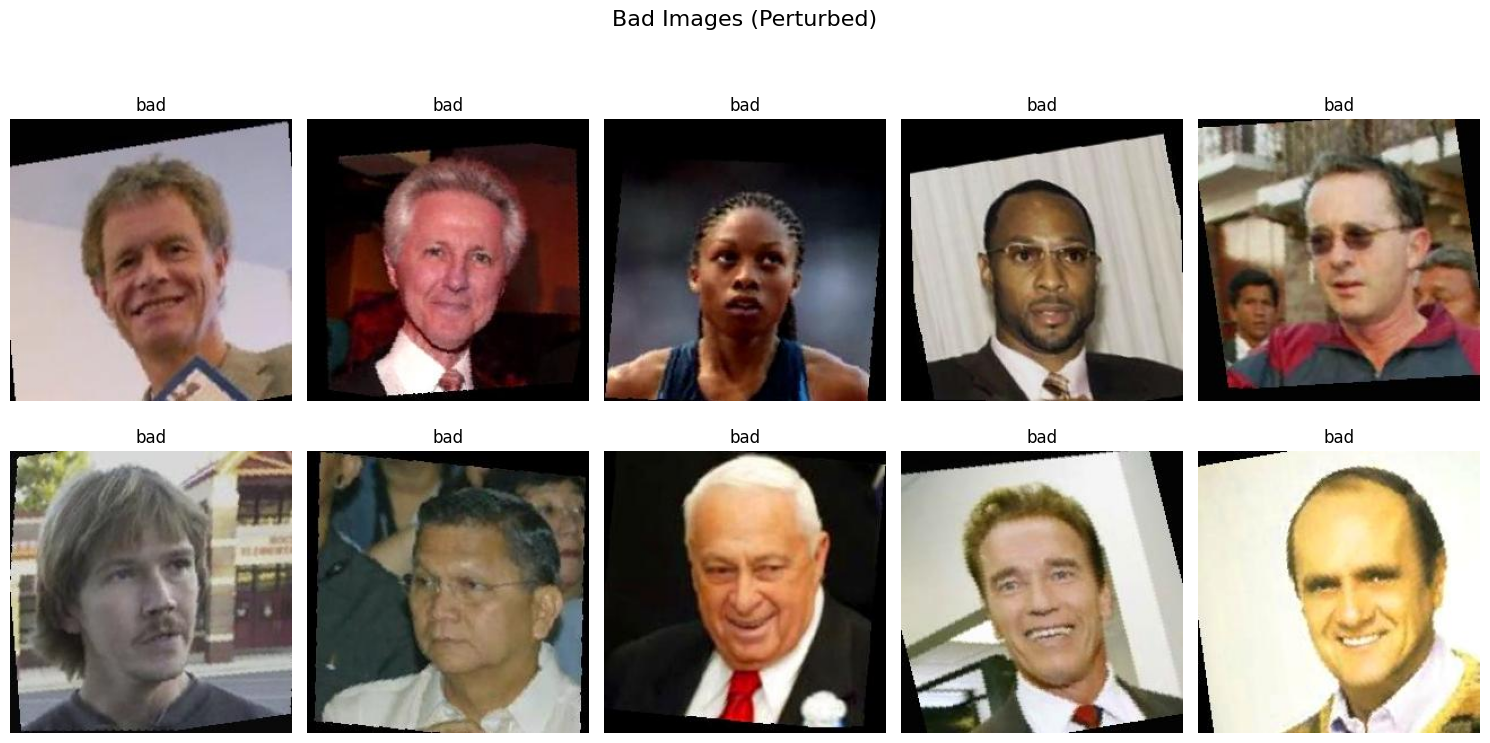

In [ ]:
import fiftyone as fo

dataset_name = "lfw_organized"
fo_dataset = fo.load_dataset(dataset_name)

sorted_view = fo_dataset.sort_by("filepath")

grouped_view = fo_dataset.group_by("classification.label")

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

def show_image_grid(samples, grid_size=(2, 5), figsize=(15, 8), title=None):
    """Display a grid of images from FiftyOne samples."""
    rows, cols = grid_size
    total = rows * cols
    samples_to_show = samples[:total]

    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    fig.suptitle(title if title else "Image Grid", fontsize=16)

    for i, sample in enumerate(samples_to_show):
        row = i // cols
        col = i % cols

        img = Image.open(sample.filepath)

        if rows > 1:
            ax = axes[row, col]
        else:
            ax = axes[col]

        ax.imshow(img)
        ax.set_title(f"{sample.classification.label}")
        ax.axis("off")

    for i in range(len(samples_to_show), total):
        row = i // cols
        col = i % cols
        if rows > 1:
            axes[row, col].axis("off")
        else:
            axes[col].axis("off")

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

good_samples = fo_dataset.match({"classification.label": "good"})
show_image_grid(good_samples, title="Good Images (Original)")

bad_samples = fo_dataset.match({"classification.label": "bad"})
show_image_grid(bad_samples, title="Bad Images (Perturbed)")

session = fo.launch_app(grouped_view)